# Diabetes Prediction with KNN

## Import Library 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease

## Import Data

In [2]:
df = pd.read_csv("data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Adapun dataset dapat diakses di link berikut : https://archive.ics.uci.edu/ml/datasets/diabetes

In [3]:
df.shape

(768, 9)

Data terdiri dari 768 baris dan 9 kolom.

In [4]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Tipe data telah sesuai.

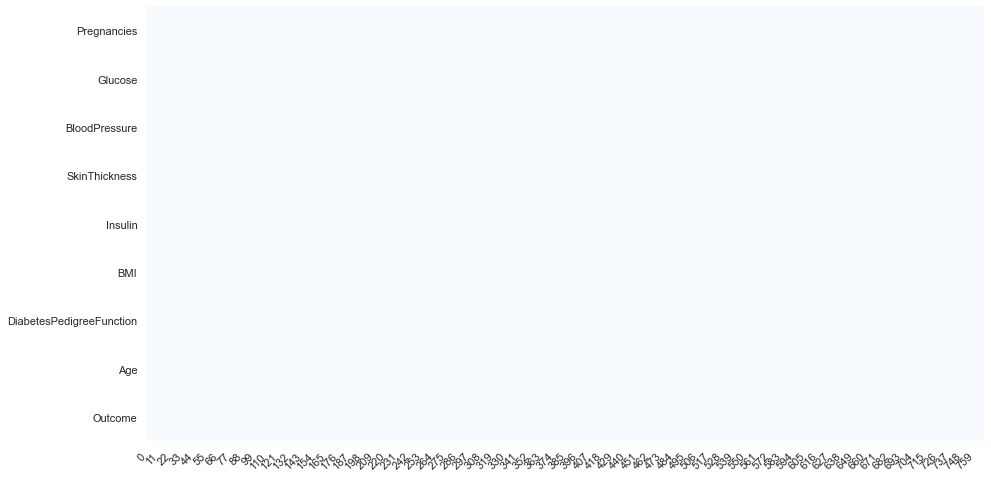

In [5]:
plot_missing_value(df)

Data telah bersih.

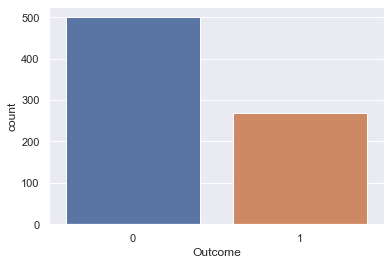

In [6]:
sns.countplot(df.Outcome);

In [7]:
df.Outcome.value_counts(normalize=True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

Target variabel masih dapat dikatakan balanced.

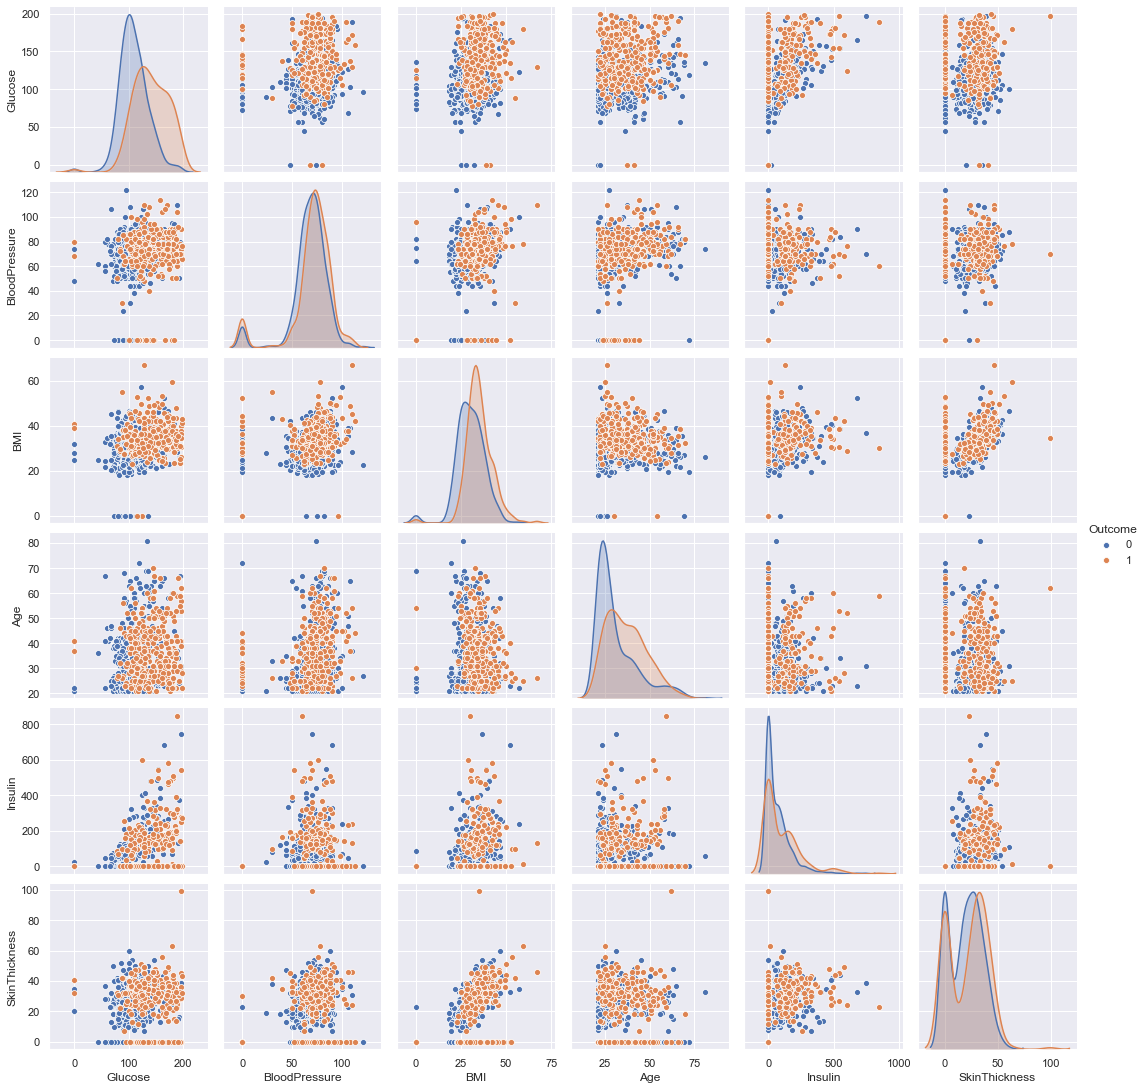

In [8]:
sns.pairplot(df, hue='Outcome', vars=['Glucose','BloodPressure','BMI','Age','Insulin','SkinThickness']);

## Dataset Splitting

In [9]:
X = df.drop(columns="Outcome")
y = df.Outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## Modeling

In [10]:
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp
from sklearn.neighbors import KNeighborsClassifier

In [11]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
353,1,90,62,12,43,27.2,0.580,24
711,5,126,78,27,22,29.6,0.439,40
373,2,105,58,40,94,34.9,0.225,25
46,1,146,56,0,0,29.7,0.564,29
682,0,95,64,39,105,44.6,0.366,22


In [12]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ['Pregnancies','Glucose','BloodPressure','SkinThickness',
                                            'Insulin','BMI','DiabetesPedigreeFunction','Age']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])


model = GridSearchCV(pipeline, gsp.knn_params, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.0s


{'algo__n_neighbors': 23, 'algo__p': 1, 'algo__weights': 'uniform'}
0.7687296416938111 0.7736238837798214 0.7597402597402597


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   10.1s finished


## Features Important 

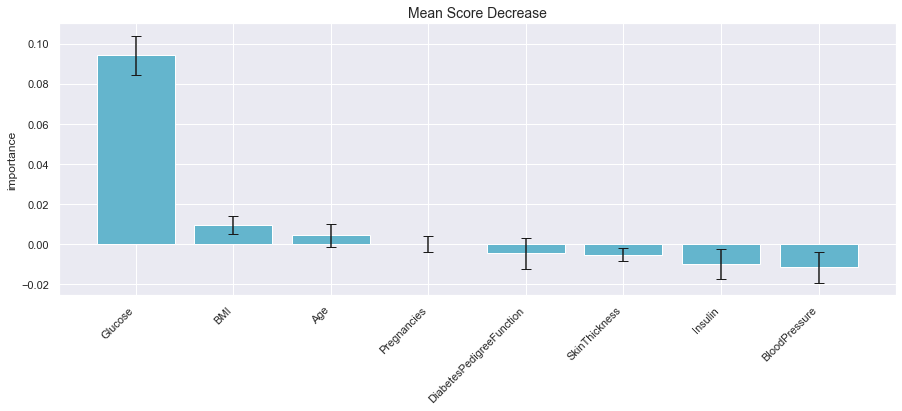

In [13]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)

Glukosa menjadi fitur paling penting dalam memprediksi seseorang menderita diabetes atau tidak.

## Polynomial Features

In [14]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust', poly=2), ['Pregnancies','Glucose','BloodPressure','SkinThickness',
                                            'Insulin','BMI','DiabetesPedigreeFunction','Age']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])


model = GridSearchCV(pipeline, gsp.knn_poly_params, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 1260 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 1960 tasks      | elapsed:  1.3min


{'algo__n_neighbors': 23, 'algo__p': 1, 'algo__weights': 'uniform', 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.7687296416938111 0.7736238837798214 0.7597402597402597


[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:  1.9min finished


Setelah dilakukan polynomial features tidak terjadi perubahan skor (akurasi) pada train, val dan test.

## Fine Tuning

In [15]:
gsp.knn_params

{'algo__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
 'algo__weights': ['uniform', 'distance'],
 'algo__p': [1, 1.5, 2]}

In [16]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ['Pregnancies','Glucose','BloodPressure','SkinThickness',
                                            'Insulin','BMI','DiabetesPedigreeFunction','Age']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])


parameter = {'algo__n_neighbors': [22, 23, 24],
             'algo__weights': ['uniform', 'distance'],
             'algo__p': [1, 1.5, 2]}


model = GridSearchCV(pipeline, parameter, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'algo__n_neighbors': 23, 'algo__p': 1, 'algo__weights': 'uniform'}
0.7687296416938111 0.7736238837798214 0.7597402597402597


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.4s finished


Setelah dilakukan fine tuning tidak terjadi perubahan skor pada train, val dan test yang berarti kita telah mendapatkan hyperparameter yang optimal.

## Evaluasi 

In [17]:
from jcopml.plot import plot_classification_report, plot_confusion_matrix

In [18]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       400
           1       0.78      0.47      0.59       214

    accuracy                           0.77       614
   macro avg       0.77      0.70      0.71       614
weighted avg       0.77      0.77      0.75       614


Test report
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       100
           1       0.72      0.52      0.60        54

    accuracy                           0.76       154
   macro avg       0.75      0.70      0.72       154
weighted avg       0.75      0.76      0.75       154



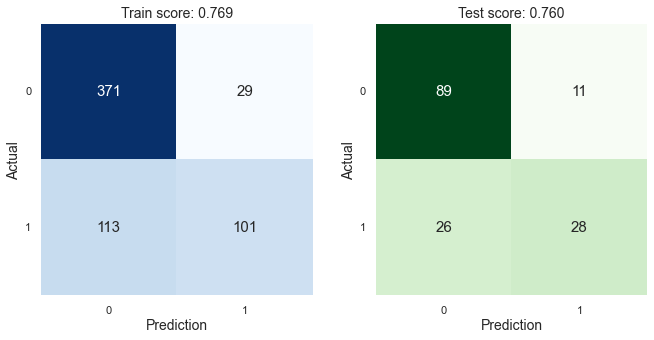

In [19]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

 ## Save Model

In [20]:
save_model(model.best_estimator_, "diabetes.pkl")

Model is pickled as model/diabetes.pkl
